In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from itertools import product
from simulation_utils import *
from test_utils import *

from os import chdir

from tqdm.auto import tqdm
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.style.use('ggplot')


In [2]:
def simulate(n_reps = 3, n_sample=500, n_quant = 128,
                kernel_X = 'constant',sig_X=5,
                kernel_Y = 'constant',sig_Y=5,
                sig_Z=5,beta1=1,
                box_params = {'max_depth':1,'n_estimators':200,'eta':0.1},
                L2_pen=1,n_splits=5,
                dependency = 0):

    (gam_plug,gam_corrected,gam_double,
        T_plug,T_corrected,T_double,
        sig_list,sigd_list) = ([] for _ in range(8))

    data_sampler = cox_sampler(sig_X,sig_Y,sig_Z,dependency,beta1,kernel_X,kernel_Y,n_quant)
    data_sampler.scale_and_set_baseline()

    for _ in tqdm(range(n_reps), leave=False):
        X,Y,Z,tau = data_sampler.sample_all(n_sample)

        g_p, g_c, sig, best_params = compute_gamma(tau,Z,X,box_params,n_quant,L2_pen=L2_pen,cross_validate=True)
        g_d, sig_d = compute_gamma_double(tau,Z,X,best_params, n_quant, n_splits=n_splits,L2_pen=L2_pen)

        gam_plug.append(g_p)
        gam_corrected.append(g_c)
        gam_double.append(g_d)
        T_plug.append(np.linalg.norm(g_p,ord=np.inf))
        T_corrected.append(np.linalg.norm(g_c,ord=np.inf))
        T_double.append(np.linalg.norm(g_d,ord=np.inf))
        sig_list.append(sig)
        sigd_list.append(sig_d)
    
    df = pd.DataFrame({
        "gam_plug":gam_plug,
        "gam_corrected":gam_corrected,
        "gam_double":gam_double,
        "T_plug":T_plug,
        "T_corrected":T_corrected,
        "T_double":T_double,
        "sigma":sig_list,
        "sigma_double":sigd_list,
        "n_sample": n_sample*np.ones(n_reps),
        "beta1": beta1*np.ones(n_reps),
        "kernel_X": [kernel_X]*n_reps,
        "kernel_Y": [kernel_Y]*n_reps,
        "alt_param": [dependency]*n_reps
    })
    return df

In [9]:
simulation_data = []

## Simulation settings
kernel_list = ['gaussian']
#kernel_list = ['constant']
beta_list = [0]
sample_sizes = [1000]
dependency_param = [0]
n_sim = len(kernel_list) * len(beta_list) * len(sample_sizes) * len(dependency_param)
param_grid = product(kernel_list,beta_list,sample_sizes,dependency_param)

for kernel,beta_1,sample_size,dependency in tqdm(param_grid, position = 0, leave=True, total=n_sim):
    sim_data = simulate(
        n_reps = 100, n_sample=sample_size,
        sig_X=1, kernel_X=kernel,
        sig_Y=5, kernel_Y=kernel,
        sig_Z=5,
        beta1=beta_1,
        box_params = {'max_depth':2,'n_estimators':200,'eta':0.1},
        L2_pen=0.001,n_splits=5,
        dependency=dependency
    )
    simulation_data.append(sim_data)
full_data = pd.concat(simulation_data)

100%|██████████| 1/1 [04:59<00:00, 299.67s/it]


In [8]:
path = '/Users/bwq666/Documents/BoxHed/'
if 1:
    with open(path+'/sim_data/' + 'dml_example2.pkl', 'wb') as f:
        pickle.dump(full_data, f)

if 0:
    with open(path+'/sim_data/' + 'full_data_independent1.pkl', 'rb') as f:
        #sim_data,n_samples = pickle.load(f)
        full_data2 = pickle.load(f)


In [7]:
full_data

,gam_plug,gam_corrected,gam_double,T_plug,T_corrected,T_double,sigma,sigma_double,n_sample,beta1,kernel_X,kernel_Y,alt_param
0,"[4.17762472017019e-06, -8.499741411433325e-05,...","[4.17762472017019e-06, -0.00034140845149584686...","[5.372340730292779e-06, -0.0001112571437932118...",0.201942,0.182380,0.016638,"[0.0, 0.00029946852722062095, 0.00059955025774...","[0.0, 1.4715078341717659e-05, 7.75077680166888...",500.0,1.0,constant,constant,0
1,"[3.5437937682017773e-06, -5.2618386834759175e-...","[3.5437937682017773e-06, -0.000190003385069356...","[3.216211500630695e-06, 1.0239121072613235e-05...",0.186597,0.138477,0.014905,"[0.0, 0.00011148945590425679, 0.00031016301349...","[0.0, 5.773588718970316e-06, 6.861359112913631...",500.0,1.0,constant,constant,0
2,"[-1.993030456143126e-05, 1.265053771970536e-05...","[-1.993030456143126e-05, 0.0005432910996027364...","[-1.2514842025496013e-05, -4.1518242379528345e...",0.129557,0.144276,0.015665,"[0.0, 7.693186747768071e-05, 0.000353506115641...","[0.0, 9.357750190668294e-07, 4.755822933455357...",500.0,1.0,constant,constant,0
3,"[-6.481902287061888e-06, 0.0001279413980367183...","[-6.481902287061888e-06, 0.0002038633309875233...","[-3.2102890771483164e-06, -3.709343276874703e-...",0.205584,0.095389,0.010031,"[0.0, 0.0006683234119402826, 0.001343592300280...","[0.0, 0.00013337915239587263, 0.00018408307700...",500.0,1.0,constant,constant,0
4,"[-1.7365596046730114e-05, -3.404076915613494e-...","[-1.7365596046730114e-05, -0.00049104921775871...","[-2.0767698272850992e-05, -3.388770123169238e-...",0.143306,0.135923,0.010435,"[0.0, 9.102874878058111e-05, 0.000369432935118...","[0.0, 5.475228578538827e-06, 2.685777440751976...",500.0,1.0,constant,constant,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,"[-1.9803875368984096e-05, -0.00014170209424932...","[-1.9803875368984096e-05, 0.000203869934093207...","[-2.2969266782719288e-05, -0.00010181835192128...",0.175666,0.114525,0.012600,"[0.0, 5.3507733283333496e-05, 0.00161191814415...","[0.0, 4.184481270318354e-06, 2.032586243673033...",500.0,1.0,constant,constant,0
996,"[-2.3793880227019122e-05, -0.00030295965551555...","[-2.3793880227019122e-05, 0.000255256925544375...","[-2.2829275635813918e-05, -0.00036436959496229...",0.184099,0.155574,0.013014,"[0.0, 0.00016102416164332764, 0.00051535922503...","[0.0, 2.5668933346590576e-05, 5.46120540630755...",500.0,1.0,constant,constant,0
997,"[-6.911437436456828e-06, 0.0002243456664273812...","[-6.911437436456828e-06, -0.001120266833189593...","[-7.67572940463374e-06, 0.0002598276123034266,...",0.207254,0.145422,0.014620,"[0.0, 0.00043531874834445094, 0.00088518847419...","[0.0, 2.5400486726244975e-05, 3.24337001752399...",500.0,1.0,constant,constant,0
998,"[-9.386117249892764e-06, 0.0003835065725081283...","[-9.386117249892764e-06, 0.0004944244844364583...","[-1.1667306133190085e-05, 0.000303798673257736...",0.154825,0.145483,0.023862,"[0.0, 0.0006357985466536763, 0.000889678478046...","[0.0, 4.1811203027755615e-05, 6.11122938370725...",500.0,1.0,constant,constant,0


In [12]:
sim_data = simulate(
    n_reps = 30, n_sample=200, n_quant=128,
    sig_X=5, kernel_X='constant',
    sig_Y=5, kernel_Y='constant',
    sig_Z=5,
    beta1=1,
    box_params = {'max_depth':2,'n_estimators':200,'eta':0.1},
    L2_pen=0.0001,n_splits=5,
    dependency=0
)

In [17]:
p_value_corr = lambda x: 1-BM_supnorm_cdf(np.sqrt(x[2])*x[0]/np.sqrt(x[1][-1])) # x = (statistic, variance, samplesize)
p_value_double = lambda x: 1-BM_supnorm_cdf(np.sqrt(x[2])*x[0]*np.sqrt(4/5)/np.sqrt(x[1][-1])) # x = (statistic, variance, samplesize)
#sim_data['p_plug'] = sim_data[['T_plug','sigma','n_sample']].apply(p_value_corr,axis=1)
sim_data['p_corr'] = sim_data[['T_corrected','sigma','n_sample']].apply(p_value_corr,axis=1)
sim_data['p_double'] = sim_data[['T_double','sigma_double','n_sample']].apply(p_value_double,axis=1)

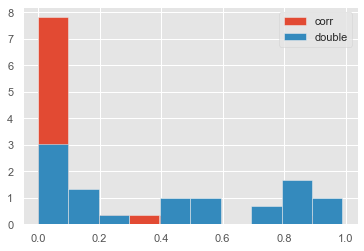

In [19]:
plt.hist(sim_data['p_corr'],density=True,label="corr")
plt.hist(sim_data['p_double'],density=True,label="double")
plt.legend()
plt.show()